In [1]:
# Gerekli Kütüphanelerin Yüklenmesi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from IPython.display import display
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score

# Görselleştirme ayarı
sns.set_style("whitegrid")

Veri Seti Boyutu: (11685, 69)


/tmp/ipython-input-484374627.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Kingdom', data=df, order=df['Kingdom'].value_counts().index, palette='viridis')


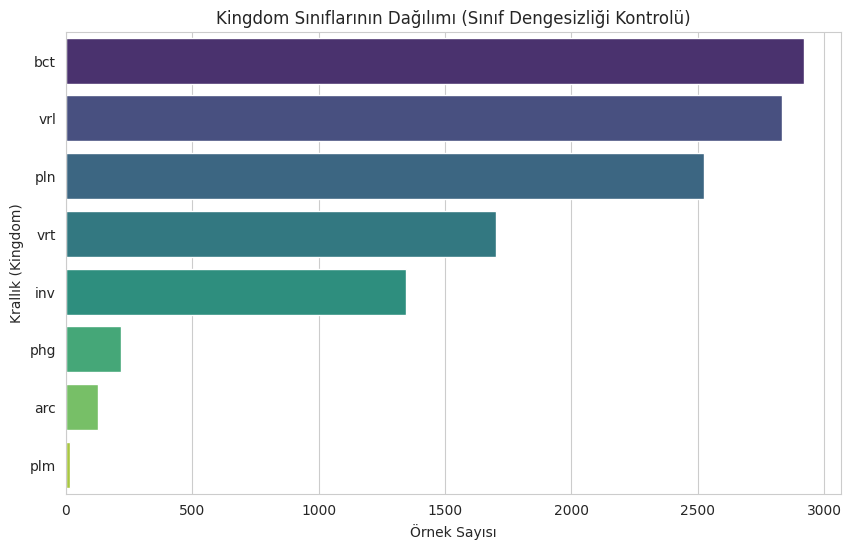

,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
0,vrl,0,100217,1995,Epizootic haematopoietic necrosis virus,0.01654,0.01203,0.00050,0.00351,0.01203,...,0.00451,0.01303,0.03559,0.01003,0.04612,0.01203,0.04361,0.00251,0.00050,0.00000
1,vrl,0,100220,1474,Bohle iridovirus,0.02714,0.01357,0.00068,0.00678,0.00407,...,0.00136,0.01696,0.03596,0.01221,0.04545,0.01560,0.04410,0.00271,0.00068,0.00000
2,vrl,0,100755,4862,Sweet potato leaf curl virus,0.01974,0.0218,0.01357,0.01543,0.00782,...,0.00596,0.01974,0.02489,0.03126,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144
3,vrl,0,100880,1915,Northern cereal mosaic virus,0.01775,0.02245,0.01619,0.00992,0.01567,...,0.00366,0.01410,0.01671,0.03760,0.01932,0.03029,0.03446,0.00261,0.00157,0.00000
4,vrl,0,100887,22831,Soil-borne cereal mosaic virus,0.02816,0.01371,0.00767,0.03679,0.01380,...,0.00604,0.01494,0.01734,0.04148,0.02483,0.03359,0.03679,0.00000,0.00044,0.00131


In [2]:
# Veri setinin yüklenmesi
df = pd.read_csv("codon_usage.csv", low_memory=False)

print("Veri Seti Boyutu:", df.shape)

# Kingdom sınıf dağılımının görselleştirilmesi
plt.figure(figsize=(10, 6))
sns.countplot(y='Kingdom', data=df, order=df['Kingdom'].value_counts().index, palette='viridis')
plt.title('Kingdom Sınıflarının Dağılımı (Sınıf Dengesizliği Kontrolü)')
plt.xlabel('Örnek Sayısı')
plt.ylabel('Krallık (Kingdom)')
plt.show()

# İlk 5 satırı göster:
display(df.head())

In [3]:
# 3. Ön Tanımlamalar
# Kodon sütunları (5. sütundan itibaren)
codon_cols = df.columns[5:]
# Diğer sayısal sütunlar (Ncodons, DNAtype)
other_numeric_cols = ['Ncodons', 'DNAtype']
# Tüm sayısal özellikler
numeric_features = list(codon_cols) + other_numeric_cols

print("--- Temizlik Başlangıcı ---")
for col in numeric_features:
    if df[col].dtype == 'object':
        df[col] = pd.to_numeric(
            df[col].astype(str).str.replace(",", ".", regex=False),
            errors="coerce"
        )

# İhtiyaç olmayan tanımlayıcı sütunları çıkar
df_cleaned = df.drop(columns=['SpeciesID', 'SpeciesName']).copy()

--- Temizlik Başlangıcı ---


In [4]:
# 4. Veri Ayırma (Split) - Imputation'dan Önce
X = df_cleaned.drop(columns=['Kingdom'])
y = df_cleaned['Kingdom']

# %80 Eğitim / %20 Test, Krallığa göre katmanlı
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Eğitim ve test setlerini tek DataFrame'lerde birleştirme
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print("\n--- Veri Ayırma Sonuçları ---")
print(f"X_train Boyutu: {X_train.shape}")
print(f"X_test Boyutu: {X_test.shape}")


--- Veri Ayırma Sonuçları ---
X_train Boyutu: (9348, 66)
X_test Boyutu: (2337, 66)


In [5]:
# 5. Eksik Değer Doldurma (Imputation)

# Train setindeki her bir sayısal sütunun ortalamasını hesapla
# Bu ortalamayı, hem Train hem de Test setini doldurmak için kullanma işlemi
train_means = train_df[numeric_features].mean()

# Train ve Test setlerini, Train setinin ortalamaları ile doldur
train_df[numeric_features] = train_df[numeric_features].fillna(train_means)
test_df[numeric_features] = test_df[numeric_features].fillna(train_means)

print("Eksik Değer Doldurma Tamamlandı. Test seti, Train ortalaması ile dolduruldu.")

# --- Encoding (Hedef Değişken Kodlama) ---
le = LabelEncoder()
train_df['Kingdom_Encoded'] = le.fit_transform(train_df['Kingdom'])
test_df['Kingdom_Encoded'] = le.transform(test_df['Kingdom'])

print("Krallık Kodlaması:", dict(zip(le.classes_, le.transform(le.classes_))))

# --- Scaling (Ölçeklendirme) ---
scaler = StandardScaler()

# Scaler'ı sadece eğitim verisine fit et
scaler.fit(train_df[numeric_features])

# Train ve Test setlerini ölçekle
train_df[numeric_features] = scaler.transform(train_df[numeric_features])
test_df[numeric_features] = scaler.transform(test_df[numeric_features])

print("Ölçeklendirme Tamamlandı. Ncodons ve Kodonlar Standardize Edildi.")

Eksik Değer Doldurma Tamamlandı. Test seti, Train ortalaması ile dolduruldu.
Krallık Kodlaması: {'arc': np.int64(0), 'bct': np.int64(1), 'inv': np.int64(2), 'phg': np.int64(3), 'plm': np.int64(4), 'pln': np.int64(5), 'vrl': np.int64(6), 'vrt': np.int64(7)}
Ölçeklendirme Tamamlandı. Ncodons ve Kodonlar Standardize Edildi.


In [6]:
# 6. Nihai X ve y setlerini oluştur
X_train_final = train_df.drop(columns=['Kingdom', 'Kingdom_Encoded'])
y_train_final = train_df['Kingdom_Encoded']
X_test_final = test_df.drop(columns=['Kingdom', 'Kingdom_Encoded'])
y_test_final = test_df['Kingdom_Encoded']

# Sonuçları CSV olarak kaydet
X_train_final.to_csv('X_train_final_Adim.csv', index=False)
X_test_final.to_csv('X_test_final_Adim.csv', index=False)
pd.DataFrame({'Kingdom_Encoded': y_train_final.values, 'Kingdom_Original': train_df['Kingdom'].values}).to_csv('y_train_encoded_final_Adim.csv', index=False)
pd.DataFrame({'Kingdom_Encoded': y_test_final.values, 'Kingdom_Original': test_df['Kingdom'].values}).to_csv('y_test_encoded_final_Adim.csv', index=False)

print("Tüm hazırlık adımları tamamlandı. Veriler dosyalara kaydedildi.")

Tüm hazırlık adımları tamamlandı. Veriler dosyalara kaydedildi.


In [7]:
# --- 4. KNN İçin Öznitelik Mühendisliği (FE) ---

# KNN için ayrı bir DataFrame kopyası oluşturma
X_train_knn = X_train_final.copy()
X_test_knn = X_test_final.copy()

print("\n--- 4. KNN İçin Öznitelik Mühendisliği (FE - Ortak Oran Tekniği) ---")

# GC/AU Oranları
gc_rich_codons = [ # GC-Yoğun Kodonlar
    'GGU', 'GGC', 'GGA', 'GGG', 'GCU', 'GCC', 'GCA', 'GCG',
    'CCU', 'CCC', 'CCA', 'CCG', 'CGU', 'CGC', 'CGA', 'CGG',
    'UGU', 'UGC', 'GAU', 'GAC', 'GAA', 'GAG', 'CAU', 'CAC',
    'CAA', 'CAG', 'AAG', 'AGG', 'UGG'
]
at_rich_codons = [ # AU-Yoğun Kodonlar
    'UUU', 'UUC', 'UUA', 'UUG', 'AUU', 'AUC', 'AUA', 'AAA',
    'AAU', 'AAC', 'UAU', 'UAC', 'UAA', 'UAG', 'UGA'
]

existing_codons = X_train_knn.columns[4:]
gc_rich_codons = [c for c in existing_codons if c in gc_rich_codons]
at_rich_codons = [c for c in existing_codons if c in at_rich_codons]

# Yeni Özellik 1- GC-Yoğun Kodon Toplamı (GC_SCORE)
X_train_knn['GC_SCORE'] = X_train_knn[gc_rich_codons].sum(axis=1)
X_test_knn['GC_SCORE'] = X_test_knn[gc_rich_codons].sum(axis=1)

# Yeni Özellik 2- GC Toplamı / AU Toplamı Oranı (GC_AU_RATIO)
at_sum_train = X_train_knn[at_rich_codons].sum(axis=1) + 1e-6
at_sum_test = X_test_knn[at_rich_codons].sum(axis=1) + 1e-6

X_train_knn['GC_AU_RATIO'] = X_train_knn['GC_SCORE'] / at_sum_train
X_test_knn['GC_AU_RATIO'] = X_test_knn['GC_SCORE'] / at_sum_test

print(f"KNN FE Sonrası Özellik Sayısı: {X_train_knn.shape[1]}")


--- 4. KNN İçin Öznitelik Mühendisliği (FE - Ortak Oran Tekniği) ---
KNN FE Sonrası Özellik Sayısı: 68


In [8]:
# Dimension Reduction (PCA Tekniği ile)
# KNN bir uzaklık tabanlı model olduğu için,
#Boyut İndirgeme (PCA) performansı artırmak için yapıldı

from sklearn.decomposition import PCA

print("\n--- 5. KNN İçin Boyut İndirgeme (DR - PCA Tekniği) ---")

# PCA modelini tanımla. Varyansın %95'ini koruyacak bileşen sayısını otomatik seç
pca = PCA(n_components=0.95, random_state=42)
pca.fit(X_train_knn) # Sadece eğitim setine fit et (Data Leakage Önlemi)

X_train_knn_pca = pca.transform(X_train_knn)
X_test_knn_pca = pca.transform(X_test_knn)

# Yeni veri setlerini DataFrame'e çevir
X_train_knn_pca_df = pd.DataFrame(X_train_knn_pca, index=X_train_knn.index)
X_test_knn_pca_df = pd.DataFrame(X_test_knn_pca, index=X_test_knn.index)

print(f"PCA Öncesi Özellik Sayısı: {X_train_knn.shape[1]}")
print(f"PCA Sonrası Bileşen Sayısı -Varyansın %95'i-: {X_train_knn_pca.shape[1]}")


--- 5. KNN İçin Boyut İndirgeme (DR - PCA Tekniği) ---
PCA Öncesi Özellik Sayısı: 68
PCA Sonrası Bileşen Sayısı -Varyansın %95'i-: 1


In [9]:
#Feature Selection (RFE Tekniği ile)
#Sarıcı Yöntem (Wrapper Method) olan RFE (Recursive Feature Elimination) yöntemini ele alma

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

print("\n--- 6. KNN İçin Öznitelik Seçimi (FS - RFE Tekniği) ---")

# RFE en iyi öznitelikleri bulmak için Logistic Regression'ı tahminci olarak kullanma eğiliminde
rfe_estimator = LogisticRegression(solver='liblinear', random_state=42)

# En iyi 20 özelliği recursive olarak seç
n_features_to_select = 20
rfe_selector = RFE(rfe_estimator, n_features_to_select=n_features_to_select, step=1)

# PCA uygulanmamış veri üzerinde fit et
rfe_selector.fit(X_train_knn, y_train_final)

X_train_rfe_selected = rfe_selector.transform(X_train_knn)
X_test_rfe_selected = rfe_selector.transform(X_test_knn)

print(f"RFE Sonrası Seçilen Öznitelik Sayısı: {X_train_rfe_selected.shape[1]} (Hedef: {n_features_to_select})")


--- 6. KNN İçin Öznitelik Seçimi (FS - RFE Tekniği) ---


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


RFE Sonrası Seçilen Öznitelik Sayısı: 20 (Hedef: 20)



--- 7. K-Nearest Neighbors -Base Model 2- Uygulama ve Karşılaştırma ---
1- Sadece FE Yapılmış Veri ile Eğitim (DR/FS Öncesi)
 Doğruluk (Accuracy - Başlangıç): 0.8853

--- KNN SINIFLANDIRMA RAPORU ---
              precision    recall  f1-score   support

           0       0.70      0.56      0.62        25
           1       0.89      0.93      0.91       584
           2       0.82      0.75      0.79       269
           3       0.78      0.66      0.72        44
           4       0.00      0.00      0.00         4
           5       0.85      0.90      0.88       505
           6       0.90      0.90      0.90       566
           7       0.97      0.92      0.95       340

    accuracy                           0.89      2337
   macro avg       0.74      0.70      0.72      2337
weighted avg       0.88      0.89      0.88      2337

2- PCA (DR) Yapılmış Veri ile Eğitim (DR Sonrası)
Doğruluk (Accuracy - PCA): 0.2944

--- KNN SINIFLANDIRMA RAPORU ---
              precision    rec

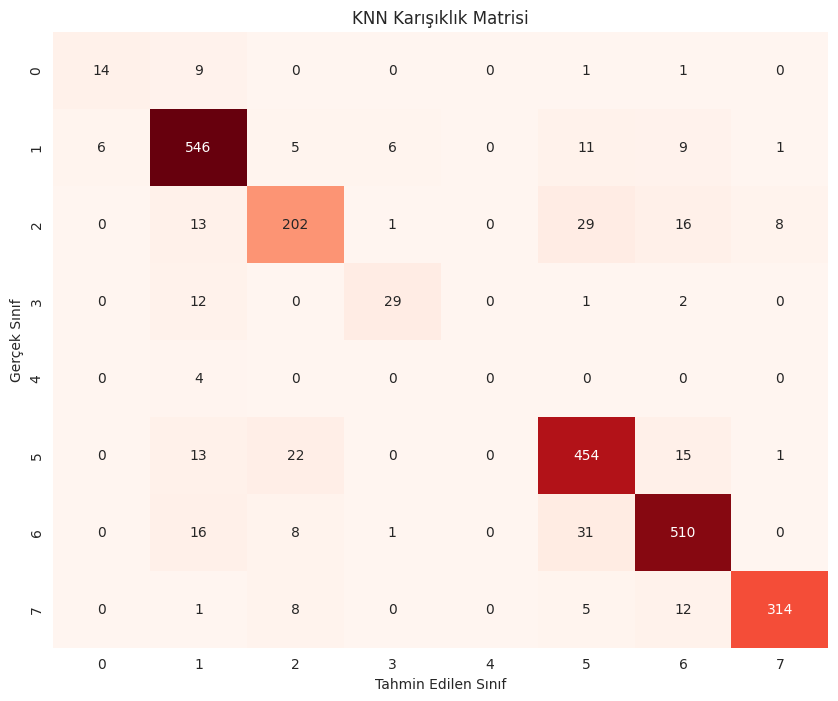

/tmp/ipython-input-2497277744.py:88: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', n_classes)


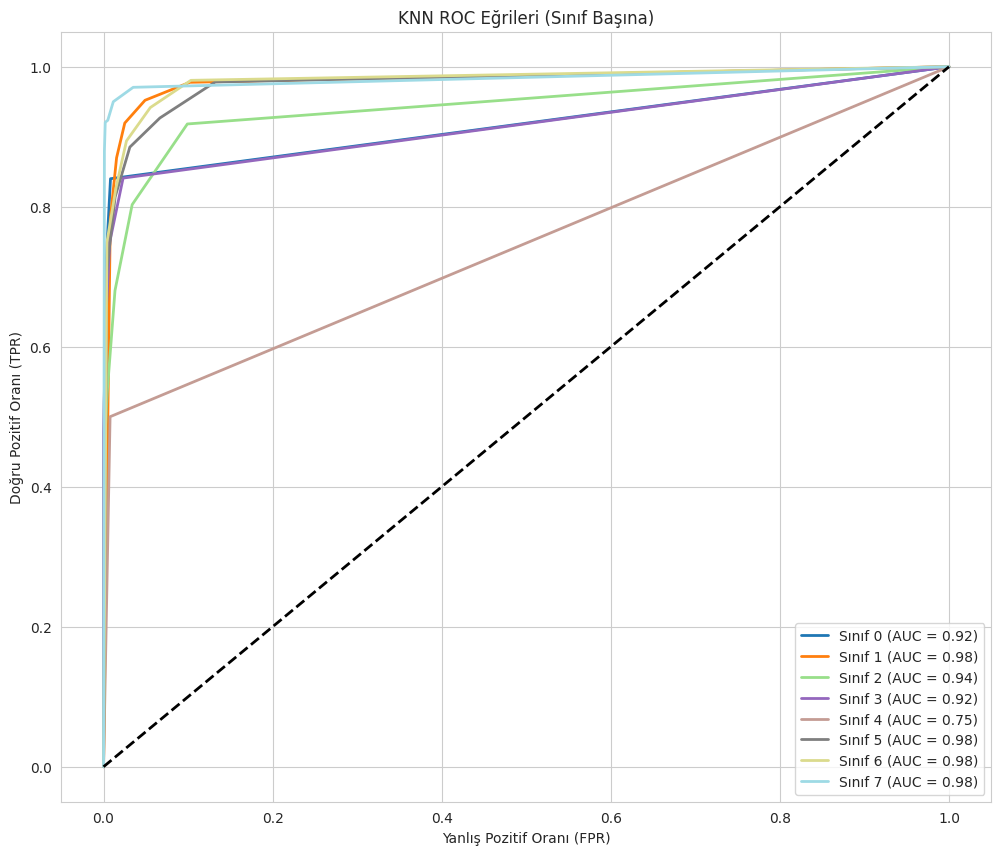


--- RFE Özellik Sıralaması ---


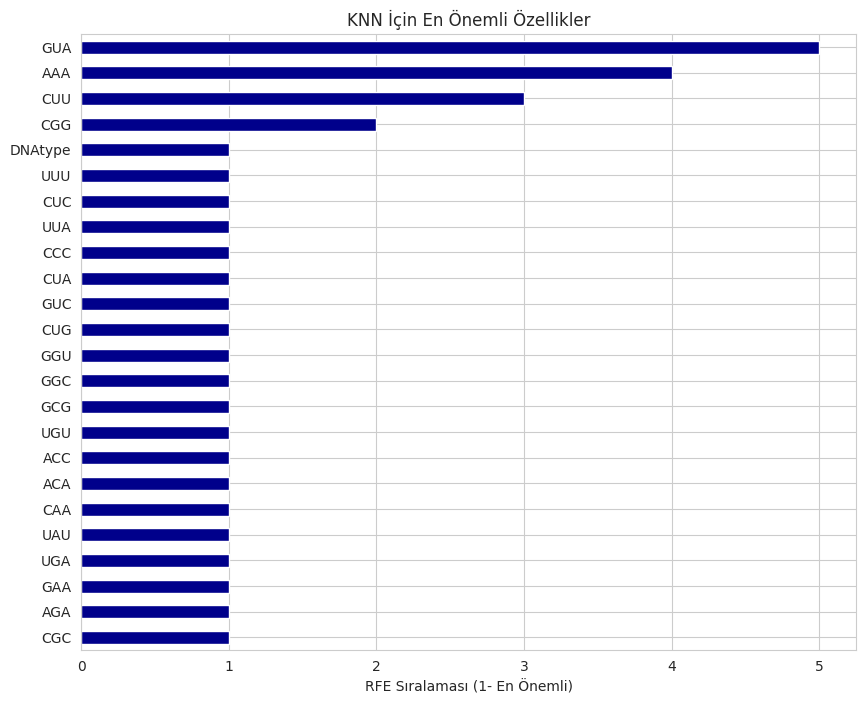

In [10]:
# KNN Base Model Uygulaması ve Karşılaştırma
# Base modelleri farklı aşamalarda deneyerek alınan sonuçları karşılaştırma adımı:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

print("\n--- 7. K-Nearest Neighbors -Base Model 2- Uygulama ve Karşılaştırma ---")

# KNN modeli: Komşu sayısını 5 olarak belirle
knn_model = KNeighborsClassifier(n_neighbors=5)

# 1- Orijinal Veri (FE Sonrası) ile Deneme (DR/FS'den Önce)
print("1- Sadece FE Yapılmış Veri ile Eğitim (DR/FS Öncesi)")
knn_model.fit(X_train_knn, y_train_final)
y_pred_original = knn_model.predict(X_test_knn)
accuracy_original = accuracy_score(y_test_final, y_pred_original)
print(f" Doğruluk (Accuracy - Başlangıç): {accuracy_original:.4f}")


print("\n--- KNN SINIFLANDIRMA RAPORU ---")
print(classification_report(y_test_final, y_pred_original, zero_division=0))


# 2- DR Yapılmış Veri (PCA Sonrası) ile Deneme
print("2- PCA (DR) Yapılmış Veri ile Eğitim (DR Sonrası)")
knn_model.fit(X_train_knn_pca_df, y_train_final)
y_pred_pca = knn_model.predict(X_test_knn_pca_df)
accuracy_pca = accuracy_score(y_test_final, y_pred_pca)
print(f"Doğruluk (Accuracy - PCA): {accuracy_pca:.4f}")


print("\n--- KNN SINIFLANDIRMA RAPORU ---")
print(classification_report(y_test_final, y_pred_pca, zero_division=0))


# 3: FS Yapılmış Veri (RFE Sonrası) ile Deneme
print("3- RFE (FS) Yapılmış Veri ile Eğitim (FS Sonrası)")
knn_model.fit(X_train_rfe_selected, y_train_final)
y_pred_rfe = knn_model.predict(X_test_rfe_selected)
accuracy_rfe = accuracy_score(y_test_final, y_pred_rfe)
print(f"Doğruluk (Accuracy - RFE): {accuracy_rfe:.4f}")

print("\n--- KNN SINIFLANDIRMA RAPORU ---")
print(classification_report(y_test_final, y_pred_rfe, zero_division=0))


print("\n--- KNN Metrik Raporu (1- En Yüksek Doğruluk) ---")
report_final_knn = classification_report(y_test_final, y_pred_original, output_dict=True, zero_division=0)
print(f" Doğruluk (Accuracy): {report_final_knn['accuracy']:.4f}")
print(f" Makro F1 Skoru: {report_final_knn['macro avg']['f1-score']:.4f}")

# *****************************************************************

# Tahmin Olasılıklarını Yeniden Hesaplama -ROC için-
# En iyi modelin olasılık tahminleri

knn_model_final = KNeighborsClassifier(n_neighbors=5)
knn_model_final.fit(X_train_knn, y_train_final)
y_proba_original = knn_model_final.predict_proba(X_test_knn)

# 1. Karmaşıklık Matrisi (Confusion Matrix)

cm = confusion_matrix(y_test_final, y_pred_original)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.title('KNN Karışıklık Matrisi')
plt.ylabel('Gerçek Sınıf')
plt.xlabel('Tahmin Edilen Sınıf')
plt.show()

# 2. ROC EĞRİSİ -Çok Sınıflı-

y_test_binarize = label_binarize(y_test_final, classes=np.unique(y_train_final))
n_classes = y_test_binarize.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    if np.sum(y_test_binarize[:, i]) == 0:
        roc_auc[i] = np.nan
        continue
    fpr[i], tpr[i], _ = roc_curve(y_test_binarize[:, i], y_proba_original[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 10))
colors = plt.cm.get_cmap('tab20', n_classes)
for i in range(n_classes):
    if not np.isnan(roc_auc[i]):
        plt.plot(fpr[i], tpr[i], color=colors(i), lw=2,
                 label=f'Sınıf {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title('KNN ROC Eğrileri (Sınıf Başına)')
plt.xlabel('Yanlış Pozitif Oranı (FPR)')
plt.ylabel('Doğru Pozitif Oranı (TPR)')
plt.legend(loc="lower right")
plt.show()


# 3- RFE Özellik Sıralaması

print("\n--- RFE Özellik Sıralaması ---")

# RFE skorları hesaplandı. En önemli özelliklerin görselleştirilmesi adımı
selected_features = X_train_knn.columns
feature_ranking = pd.Series(rfe_selector.ranking_, index=selected_features)
top_n = 15 #En iyi sıralamaya sahip ilk 15 özelliği göster

#En iyi rank'a sahip olanları (rank <= 5) göster
#Sıralamayı tersine çevirerek (rank=1 en sağda) görselleştir
best_ranked_features = feature_ranking.sort_values(ascending=True)
features_to_plot = best_ranked_features[best_ranked_features <= 5]

if not features_to_plot.empty:
    plt.figure(figsize=(10, 8))

    # Düşük Rank = Yüksek Önem
    # Rank 1 olanlar en sağda olacak şekilde sırala
    features_to_plot.sort_values(ascending=False).plot(kind='barh', color='darkblue')
    plt.title(f'KNN İçin En Önemli Özellikler')
    plt.xlabel('RFE Sıralaması (1- En Önemli)')
    plt.gca().invert_yaxis()
    plt.show()
else:
    print("Görselleştirilecek RFE Rankı 5 ve altı özellik bulunamadı.")